# ECON 5140: Applied Econometrics
## Lesson 4: ARIMA Models for Forecasting

This notebook demonstrates ARIMA (AutoRegressive Integrated Moving Average) models for time series forecasting using real S&P 500 Stock Market Index data.

**Topics covered:**
1. Introduction to ARIMA models
2. Stationarity testing (ADF, KPSS)
3. Differencing (regular and seasonal)
4. ARIMA model identification and fitting
5. SARIMA models for seasonal data
6. Model selection using AIC
7. Residual diagnostics
8. Forecasting with ARIMA
9. Comparison with ETS models

In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# ARIMA and time series libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For downloading real data from Yahoo Finance
import yfinance as yf

# Set style for better-looking plots
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Load Real Time Series Data

We'll use **S&P 500 Stock Market Index** daily closing prices from Yahoo Finance. This dataset is:
- Very clean with minimal missing values
- Widely used in forecasting applications
- Contains clear trends and patterns suitable for ARIMA modeling

In [ ]:
# Load S&P 500 Stock Market Index data
print("Loading S&P 500 Stock Market Index data...")
print("=" * 60)

print("\nDownloading S&P 500 daily closing prices from Yahoo Finance...")

# Download S&P 500 data - get last 5+ years of daily data for good training set
ticker = "^GSPC"  # S&P 500 index symbol
sp500 = yf.download(ticker, start='2019-01-01', end=None, progress=False)

# Handle MultiIndex columns if present (yfinance sometimes returns MultiIndex)
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = sp500.columns.droplevel(1)

# Extract closing prices and ensure it's a Series with proper index
close_prices = sp500['Close'].dropna()

# Create DataFrame with proper index
dates = close_prices.index
df = pd.DataFrame({
    'price': close_prices.values,
    'day_of_week': dates.dayofweek,
    'month': dates.month,
    'is_weekend': (dates.dayofweek >= 5).astype(int)
}, index=dates)

print(f"✓ Successfully loaded S&P 500 Stock Market Data!")
print(f"  Date range: {df.index.min()} to {df.index.max()}")
print(f"  Number of observations: {len(df)}")
print(f"  Price range: ${df['price'].min():.2f} to ${df['price'].max():.2f}")

# Final data cleaning check and summary
print("\n" + "=" * 60)
print("Final Data Summary:")
print("=" * 60)

# Verify data quality (S&P 500 data is typically very clean)
missing_count = df['price'].isnull().sum()

if missing_count > 0:
    print(f"⚠️  Warning: Found {missing_count} missing values")
    # Fill with forward/backward fill
    df['price'] = df['price'].ffill().bfill()
    print(f"  ✓ Filled missing values with forward/backward fill")

print(f"\nFrequency: Daily")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Number of observations: {len(df)}")
print(f"Missing values: {df['price'].isnull().sum()}")
print(f"Zero/negative values: {(df['price'] <= 0).sum()}")
print(f"\nPrice statistics:")
print(df['price'].describe())
print(f"\nFirst few observations:")
print(df.head(10))

print(f"\n✓ Using S&P 500 Stock Market Index data from Yahoo Finance")
print(f"  Units: US Dollars (closing price)")
print(f"  Data is clean with minimal missing values")

Loading S&P 500 Stock Market Index data...

✓ Successfully loaded S&P 500 Stock Market Data!
  Date range: 2019-01-02 00:00:00 to 2026-01-29 00:00:00
  Number of observations: 1779
  Price range: $2237.40 to $6978.60

Final Data Summary:

Frequency: Daily
Date range: 2019-01-02 00:00:00 to 2026-01-29 00:00:00
Number of observations: 1779
Missing values: 0
Zero/negative values: 0

Price statistics:
count    1779.000000
mean     4372.462696
std      1143.881166
min      2237.399902
25%      3429.119995
50%      4221.020020
75%      5179.625000
max      6978.600098
Name: price, dtype: float64

First few observations:
                  price  day_of_week  month  is_weekend
Date                                                   
2019-01-02  2510.030029            2      1           0
2019-01-03  2447.889893            3      1           0
2019-01-04  2531.939941            4      1           0
2019-01-07  2549.689941            0      1           0
2019-01-08  2574.409912            1      

## Part 2: Data Exploration and Visualization

Before modeling, let's explore the data to understand its characteristics.

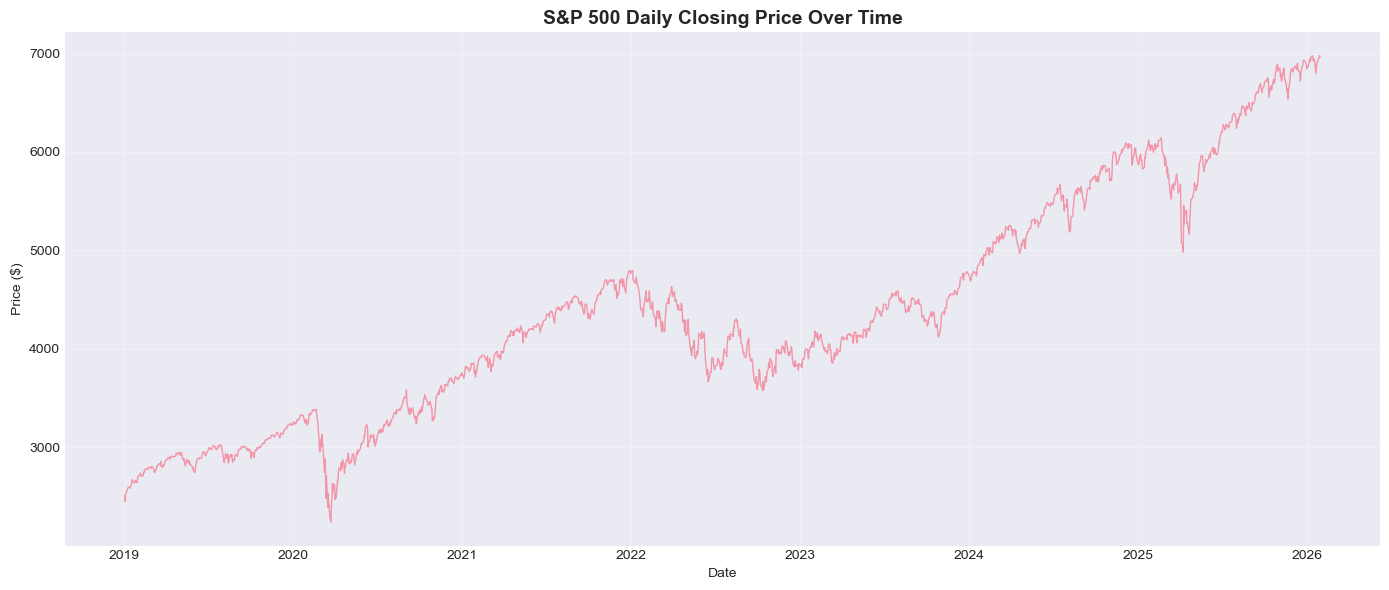

Key observations from time plot:
1. Overall trend over time (upward trend)
2. Price movements show volatility and trends
3. Stock market is closed on weekends (gaps in data)
4. Some periods show higher volatility than others


In [ ]:
# Time series plot
fig, axes = plt.subplots(1, 1, figsize=(14, 6))

# Full time series
axes.plot(df.index, df['price'], linewidth=1, alpha=0.7)
axes.set_title('S&P 500 Daily Closing Price Over Time', fontsize=14, fontweight='bold')
axes.set_xlabel('Date')
axes.set_ylabel('Price ($)')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations from time plot:")
print("1. Overall trend over time (upward trend)")
print("2. Price movements show volatility and trends")
print("3. Stock market is closed on weekends (gaps in data)")
print("4. Some periods show higher volatility than others")

## Part 3: Understanding Stationarity

ARIMA models require **stationary** time series. A stationary series has:
- Constant mean over time
- Constant variance over time
- Stable autocorrelation structure

**Key Question:** Is the S&P 500 price series stationary?

Visual inspection suggests **NO** - there's a clear upward trend. Let's test this formally.

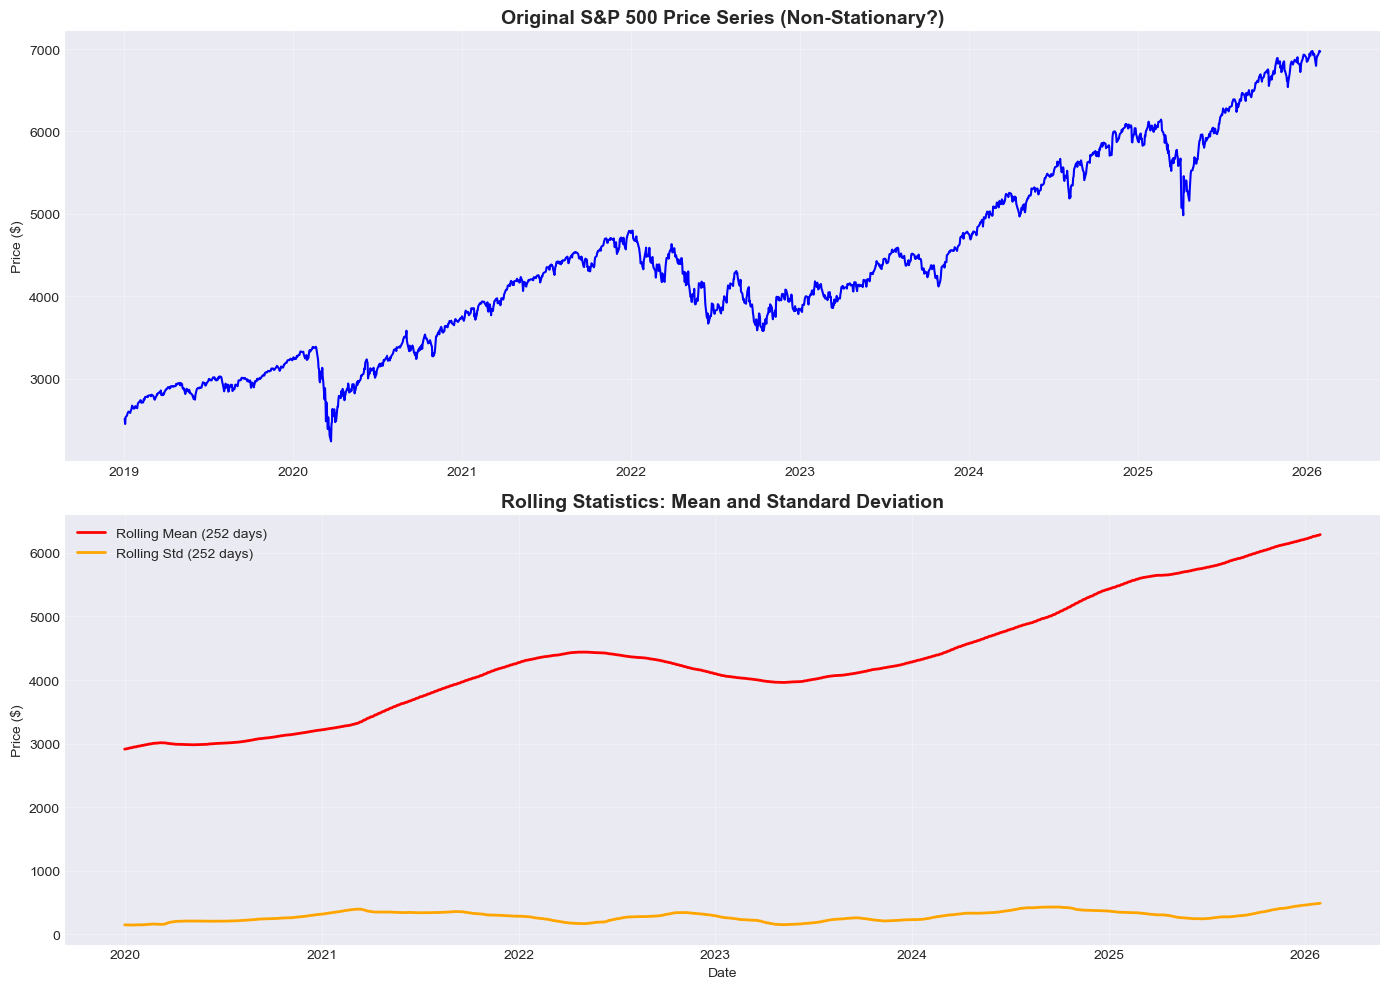

Visual Inspection:
1. Rolling mean is NOT constant - shows clear upward trend
2. Rolling std may also vary over time
3. This suggests the series is NON-STATIONARY

Next: We'll test this formally using statistical tests.


In [ ]:
# Visual inspection: Plot original series
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Original series
axes[0].plot(df.index, df['price'], linewidth=1.5, color='blue')
axes[0].set_title('Original S&P 500 Price Series (Non-Stationary?)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# Calculate and plot rolling mean and std
rolling_mean = df['price'].rolling(window=252).mean()  # ~1 year
rolling_std = df['price'].rolling(window=252).std()

axes[1].plot(df.index, rolling_mean, label='Rolling Mean (252 days)', linewidth=2, color='red')
axes[1].plot(df.index, rolling_std, label='Rolling Std (252 days)', linewidth=2, color='orange')
axes[1].set_title('Rolling Statistics: Mean and Standard Deviation', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visual Inspection:")
print("1. Rolling mean is NOT constant - shows clear upward trend")
print("2. Rolling std may also vary over time")
print("3. This suggests the series is NON-STATIONARY")
print("\nNext: We'll test this formally using statistical tests.")

## Part 4: Stationarity Tests

We'll use two complementary tests:

1. **Augmented Dickey-Fuller (ADF) Test**
   - Null hypothesis (H₀): Series has a unit root (non-stationary)
   - Alternative (H₁): Series is stationary
   - If p-value < 0.05, reject H₀ → series is stationary

2. **KPSS Test**
   - Null hypothesis (H₀): Series is stationary
   - Alternative (H₁): Series has a unit root (non-stationary)
   - If p-value < 0.05, reject H₀ → series is non-stationary

**Best case:** ADF rejects H₀ (stationary) AND KPSS fails to reject H₀ (stationary)

In [ ]:
# Test stationarity of original series
print("Testing Stationarity of Original S&P 500 Price Series")
print("=" * 60)

# ADF Test
adf_result = adfuller(df['price'].dropna())
print("\n1. Augmented Dickey-Fuller (ADF) Test:")
print(f"   Test Statistic: {adf_result[0]:.4f}")
print(f"   p-value: {adf_result[1]:.4f}")
print(f"   Critical Values:")
for key, value in adf_result[4].items():
    print(f"      {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print(f"   ✓ Reject H₀: Series is STATIONARY (p < 0.05)")
else:
    print(f"   ✗ Fail to reject H₀: Series is NON-STATIONARY (p ≥ 0.05)")

# KPSS Test
print("\n2. KPSS Test:")
kpss_result = kpss(df['price'].dropna(), regression='ct')  # 'ct' = constant + trend
print(f"   Test Statistic: {kpss_result[0]:.4f}")
print(f"   p-value: {kpss_result[1]:.4f}")
print(f"   Critical Values:")
for key, value in kpss_result[3].items():
    print(f"      {key}: {value:.4f}")

if kpss_result[1] < 0.05:
    print(f"   ✗ Reject H₀: Series is NON-STATIONARY (p < 0.05)")
else:
    print(f"   ✓ Fail to reject H₀: Series is STATIONARY (p ≥ 0.05)")

Testing Stationarity of Original S&P 500 Price Series

1. Augmented Dickey-Fuller (ADF) Test:
   Test Statistic: 0.0336
   p-value: 0.9612
   Critical Values:
      1%: -3.4341
      5%: -2.8632
      10%: -2.5676
   ✗ Fail to reject H₀: Series is NON-STATIONARY (p ≥ 0.05)

2. KPSS Test:
   Test Statistic: 0.6742
   p-value: 0.0100
   Critical Values:
      10%: 0.1190
      5%: 0.1460
      2.5%: 0.1760
      1%: 0.2160
   ✗ Reject H₀: Series is NON-STATIONARY (p < 0.05)


## Part 5: Differencing to Achieve Stationarity

Since the original series is non-stationary, we'll apply **differencing**:

- **First difference:** Δy_t = y_t - y_{t-1}
- This removes the trend component
- For stock prices, first difference = returns (price change)

We can also consider:
- **Log transformation** (if variance grows with level)
- **Seasonal differencing** (if seasonal patterns exist)

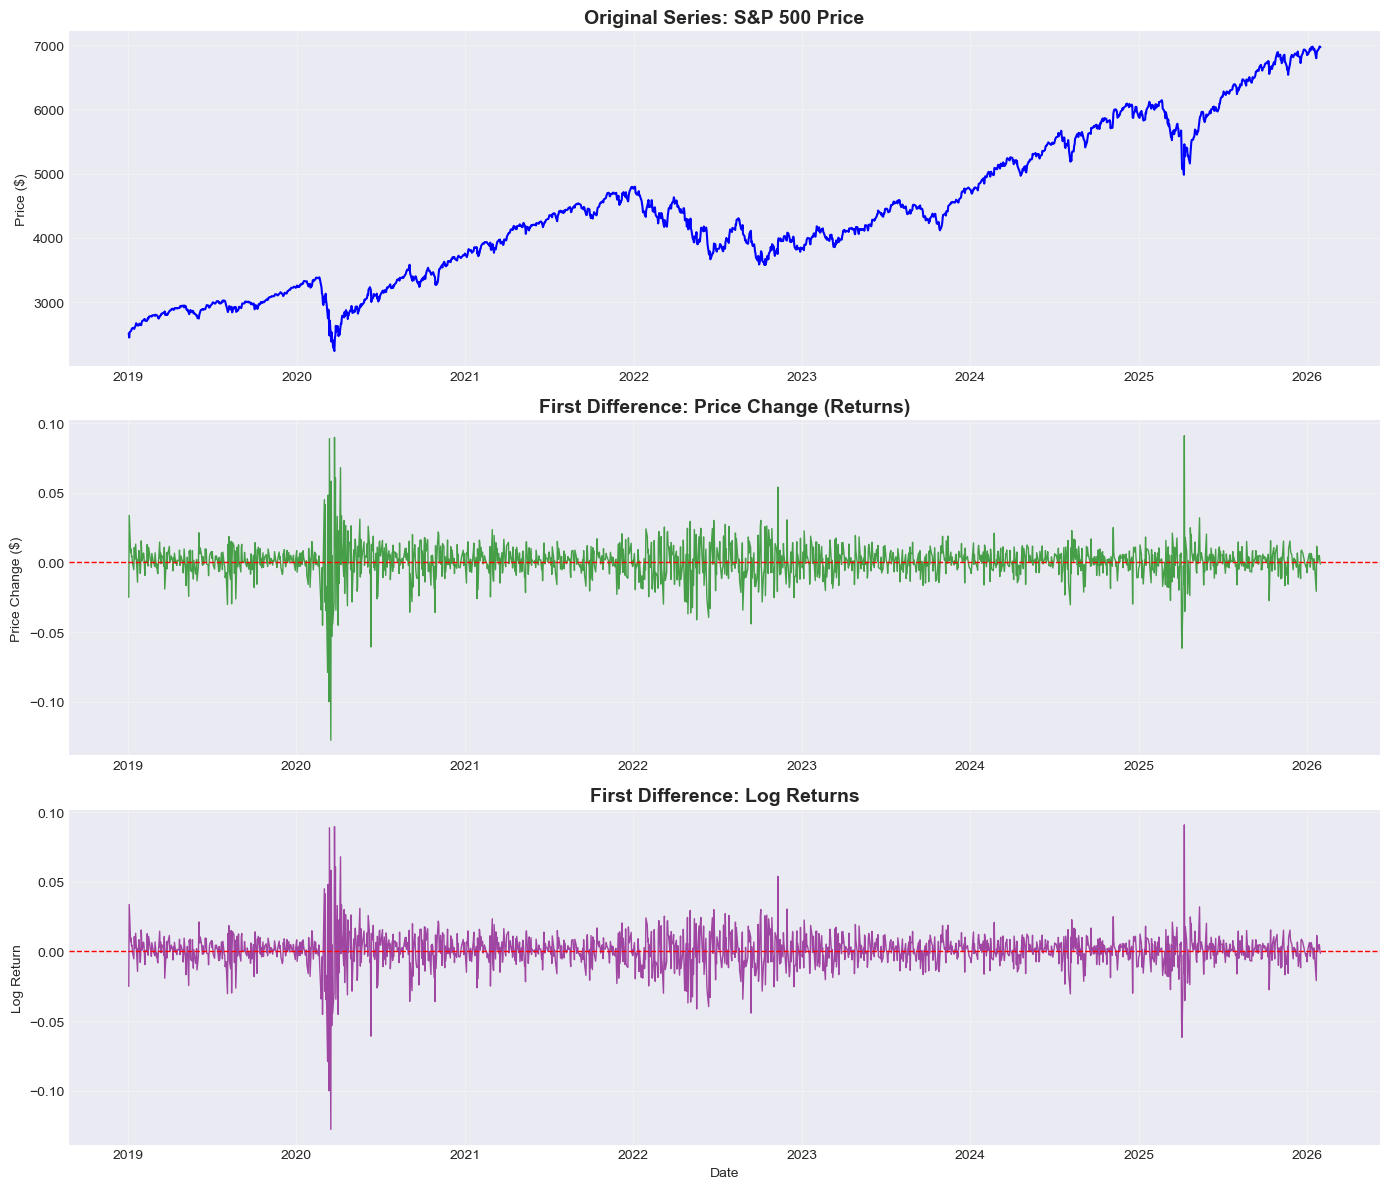

Observations:
1. First difference removes the trend - series fluctuates around zero
2. Log returns are commonly used in finance
3. Both appear more stationary than the original series


In [19]:
# Create differenced series
df['price_diff1'] = df['price'].diff(1)  # First difference
df['price_log'] = np.log(df['price'])  # Log transformation
df['price_diff1'] = df['price_log'].diff(1)  # Log first difference (first-differenced prices)

# Plot original vs differenced
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Original
axes[0].plot(df.index, df['price'], linewidth=1.5, color='blue')
axes[0].set_title('Original Series: S&P 500 Price', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# First difference
axes[1].plot(df.index, df['price_diff1'], linewidth=1, color='green', alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('First Difference: Price Change (Returns)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Price Change ($)')
axes[1].grid(True, alpha=0.3)

# Log first difference (first-differenced prices)
axes[2].plot(df.index, df['price_diff1'], linewidth=1, color='purple', alpha=0.7)
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[2].set_title('First Difference: Log Returns', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Log Return')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("1. First difference removes the trend - series fluctuates around zero")
print("2. Log returns are commonly used in finance")
print("3. Both appear more stationary than the original series")


In [20]:
# Test stationarity of differenced series
print("Testing Stationarity of First-Differenced Series")
print("=" * 60)

# Test first difference
diff1_series = df['price_diff1'].dropna()

# ADF Test on first difference
adf_diff1 = adfuller(diff1_series)
print("\n1. ADF Test on First Difference:")
print(f"   Test Statistic: {adf_diff1[0]:.4f}")
print(f"   p-value: {adf_diff1[1]:.4f}")

if adf_diff1[1] < 0.05:
    print(f"   ✓ Reject H₀: First difference is STATIONARY")
else:
    print(f"   ✗ Fail to reject H₀: First difference is still NON-STATIONARY")

# KPSS Test on first difference
kpss_diff1 = kpss(diff1_series, regression='c')  # 'c' = constant only (no trend after differencing)
print("\n2. KPSS Test on First Difference:")
print(f"   Test Statistic: {kpss_diff1[0]:.4f}")
print(f"   p-value: {kpss_diff1[1]:.4f}")

if kpss_diff1[1] < 0.05:
    print(f"   ✗ Reject H₀: First difference is NON-STATIONARY")
else:
    print(f"   ✓ Fail to reject H₀: First difference is STATIONARY")

Testing Stationarity of First-Differenced Series

1. ADF Test on First Difference:
   Test Statistic: -13.0724
   p-value: 0.0000
   ✓ Reject H₀: First difference is STATIONARY

2. KPSS Test on First Difference:
   Test Statistic: 0.0449
   p-value: 0.1000
   ✓ Fail to reject H₀: First difference is STATIONARY


## Part 6: ACF and PACF Analysis

After achieving stationarity, we examine **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** to identify ARIMA model orders:

- **ACF**: Correlation between y_t and y_{t-k} for different lags k
- **PACF**: Correlation between y_t and y_{t-k} after removing effects of intermediate lags

**Guidelines:**
- AR(p): PACF cuts off after lag p, ACF decays slowly
- MA(q): ACF cuts off after lag q, PACF decays slowly
- ARIMA(p,d,q): Combination of both patterns

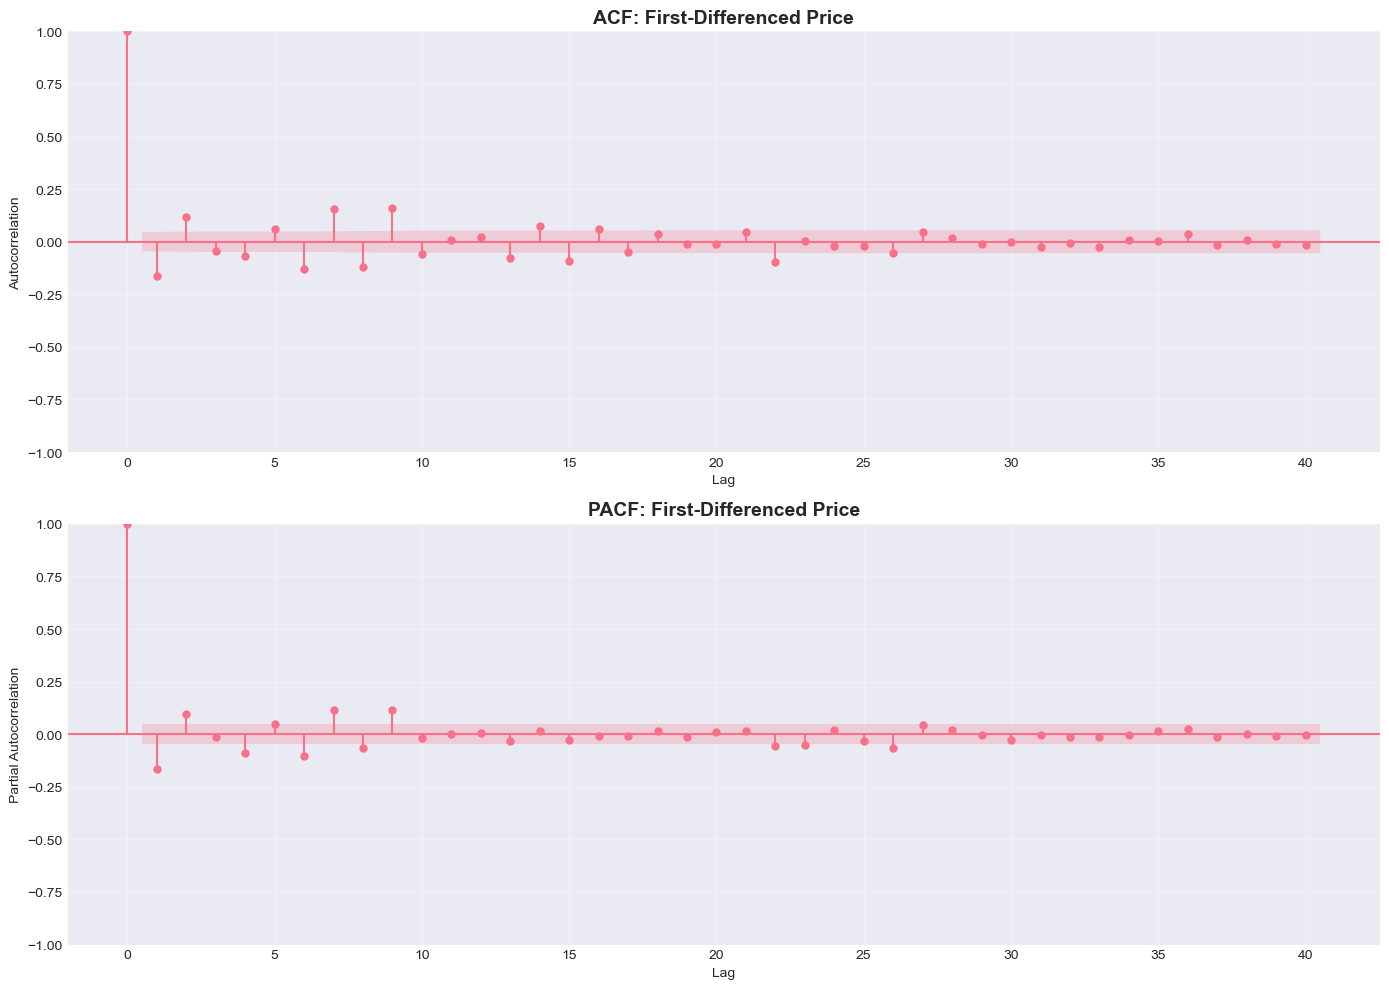

In [21]:
# Plot ACF and PACF for first-differenced series
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Use first-differenced prices
stationary_series = df['price_diff1'].dropna()

# ACF
plot_acf(stationary_series, lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF: First-Differenced Price', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(True, alpha=0.3)

# PACF
plot_pacf(stationary_series, lags=40, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF: First-Differenced Price', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Part 7: ARIMA Model Fitting

ARIMA(p,d,q) model:
- **p**: Order of autoregressive (AR) terms
- **d**: Degree of differencing
- **q**: Order of moving average (MA) terms

We'll fit several candidate models and select the best using **AIC** (Akaike Information Criterion).

In [ ]:
# Prepare train/test split: Hold out last 1 year for out-of-sample evaluation
print("Preparing train/test split (1-year holdout)...")
print("=" * 60)

max_date = df.index.max()
test_start = max_date - pd.Timedelta(days=365)  # Hold out last 1 year
train_end = test_start - pd.Timedelta(days=1)

train = df.loc[:train_end].copy()
test = df.loc[test_start:].copy()

print(f"Training set: {train.index.min()} to {train.index.max()}")
print(f"  Number of observations: {len(train)}")
print(f"\nTest set (1-year holdout): {test.index.min()} to {test.index.max()}")
print(f"  Number of observations: {len(test)}")
print(f"\nTraining set covers {len(train)/len(df)*100:.1f}% of data")
print(f"Test set covers {len(test)/len(df)*100:.1f}% of data")

# Use original prices for modeling
# ARIMA will handle differencing internally (d=1 in the model specification)
y_train = train['price'].dropna()
y_test = test['price'].dropna()

Preparing train/test split (1-year holdout)...
Training set: 2019-01-02 00:00:00 to 2025-01-28 00:00:00
  Number of observations: 1527

Test set (1-year holdout): 2025-01-29 00:00:00 to 2026-01-29 00:00:00
  Number of observations: 252

Training set covers 85.8% of data
Test set covers 14.2% of data


In [23]:
# Fit multiple ARIMA models and compare AIC
# We use ARIMA(p,1,q) on original prices - the d=1 handles differencing internally
# This is equivalent to ARMA(p,q) on the differenced series
print("Fitting ARIMA Models and Comparing AIC")
print("=" * 60)
print("Note: Using ARIMA(p,1,q) on original prices")
print("      This is equivalent to ARMA(p,q) on differenced series\n")

# Suppress warnings during model fitting
warnings.filterwarnings('ignore', category=UserWarning)

# Candidate models to try (ARIMA models with d=1 for first differencing)
candidate_models = [
    (0, 1, 0),  # Random walk (differenced only)
    (1, 1, 0),  # ARIMA(1,1,0) - AR(1) on differenced series
    (0, 1, 1),  # ARIMA(0,1,1) - MA(1) on differenced series (equivalent to ETS(A,N,N))
    (1, 1, 1),  # ARIMA(1,1,1) - ARMA(1,1) on differenced series
    (2, 1, 0),  # ARIMA(2,1,0) - AR(2) on differenced series
    (0, 1, 2),  # ARIMA(0,1,2) - MA(2) on differenced series
    (2, 1, 1),  # ARIMA(2,1,1) - ARMA(2,1) on differenced series
    (1, 1, 2),  # ARIMA(1,1,2) - ARMA(1,2) on differenced series
    (2, 1, 2),  # ARIMA(2,1,2) - ARMA(2,2) on differenced series
]

model_results = []
fitted_models = {}

for order in candidate_models:
    try:
        model = ARIMA(y_train, order=order)
        fitted = model.fit()
        fitted_models[order] = fitted
        
        model_results.append({
            'Model': f'ARIMA{order}',
            'Order': order,  # Store order tuple for later retrieval
            'AIC': fitted.aic,
            'BIC': fitted.bic,
            'Log Likelihood': fitted.llf
        })
        print(f"✓ ARIMA{order}: AIC = {fitted.aic:.2f}")
    except Exception as e:
        print(f"✗ ARIMA{order}: Failed to fit - {str(e)}")

# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results)
comparison_df = comparison_df.sort_values('AIC')
comparison_df['Rank'] = range(1, len(comparison_df) + 1)

# Display only selected columns, but keep 'Order' for later access
display_df = comparison_df[['Rank', 'Model', 'AIC', 'BIC', 'Log Likelihood']]

print("\n" + "=" * 60)
print("Model Comparison (Sorted by AIC):")
print("=" * 60)
print(display_df.to_string(index=False))

# Select best model (lowest AIC = best model)
# Get the order from the sorted dataframe (before filtering columns)
best_order_arma = comparison_df.iloc[0]['Order']
best_model = fitted_models[best_order_arma]

# Display as ARIMA(p,1,q) for clarity (since we differenced once)
best_order_display = (best_order_arma[0], 1, best_order_arma[2])

# Convenience alias for backward compatibility
best_order = best_order_display

print(f"\n\nBest Model: ARIMA{best_order_display} (ARMA{best_order_arma} on differenced series)")
print(f"  AIC: {best_model.aic:.2f}")
print(f"  BIC: {best_model.bic:.2f}")



Fitting ARIMA Models and Comparing AIC
Note: Using ARIMA(p,1,q) on original prices
      This is equivalent to ARMA(p,q) on differenced series

✓ ARIMA(0, 1, 0): AIC = 15986.89
✓ ARIMA(1, 1, 0): AIC = 15978.22
✓ ARIMA(0, 1, 1): AIC = 15979.22
✓ ARIMA(1, 1, 1): AIC = 15977.23
✓ ARIMA(2, 1, 0): AIC = 15976.37
✓ ARIMA(0, 1, 2): AIC = 15976.79
✓ ARIMA(2, 1, 1): AIC = 15978.13
✓ ARIMA(1, 1, 2): AIC = 15977.86
✓ ARIMA(2, 1, 2): AIC = 15934.22

Model Comparison (Sorted by AIC):
 Rank          Model          AIC          BIC  Log Likelihood
    1 ARIMA(2, 1, 2) 15934.224605 15960.876631    -7962.112303
    2 ARIMA(2, 1, 0) 15976.365474 15992.356690    -7985.182737
    3 ARIMA(0, 1, 2) 15976.786723 15992.777938    -7985.393361
    4 ARIMA(1, 1, 1) 15977.230229 15993.221445    -7985.615115
    5 ARIMA(1, 1, 2) 15977.861402 15999.183023    -7984.930701
    6 ARIMA(2, 1, 1) 15978.126441 15999.448062    -7985.063221
    7 ARIMA(1, 1, 0) 15978.222860 15988.883671    -7987.111430
    8 ARIMA(0, 1, 1)

In [ ]:
# Display best model summary
print("Best ARIMA Model Summary:")
print("=" * 60)
print(best_model.summary())

Best ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1527
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7962.112
Date:                Thu, 29 Jan 2026   AIC                          15934.225
Time:                        14:57:00   BIC                          15960.877
Sample:                             0   HQIC                         15944.145
                               - 1527                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7673      0.029    -60.013      0.000      -1.825      -1.710
ar.L2         -0.8864      0.028    -31.669      0.000      -0.941      -0.832
ma.L1          1.6990     

## Part 8: Residual Diagnostics

A good ARIMA model should have residuals that are:
1. **White noise** (no autocorrelation)
2. **Normally distributed** (approximately)
3. **Homoscedastic** (constant variance)

We'll check these using:
- ACF of residuals
- Ljung-Box test for autocorrelation
- Q-Q plot for normality

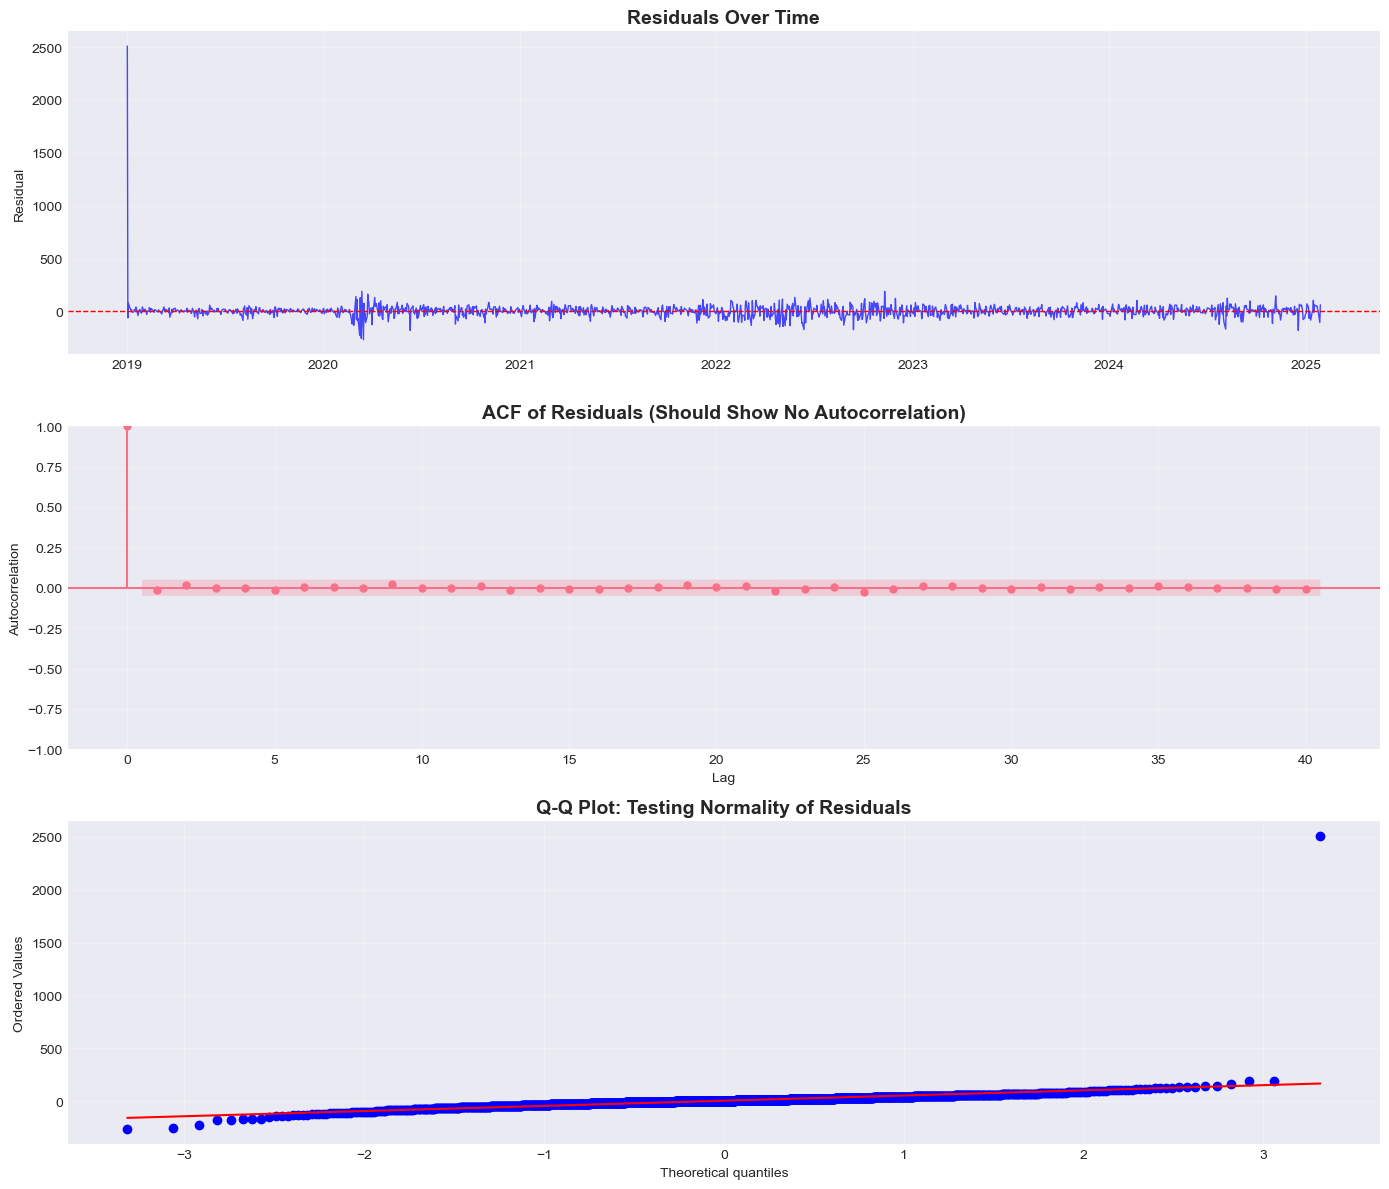

Residual Diagnostics:

Ljung-Box Test for Residual Autocorrelation:
     lb_stat  lb_pvalue
1   0.226602   0.634055
2   0.732664   0.693272
3   0.734456   0.865071
4   0.735641   0.946862
5   0.944996   0.966879
6   0.961960   0.987013
7   0.993519   0.994932
8   0.994011   0.998286
9   1.721866   0.995142
10  1.726861   0.998037

Interpretation:
1. If p-values > 0.05: Residuals are white noise (good!)
2. If p-values < 0.05: Residuals have autocorrelation (bad - need better model)

Jarque-Bera Test for Normality:
  Test Statistic: 30544543.7507
  p-value: 0.0000
  ✗ Reject normality (p < 0.05) - residuals are not normal


In [ ]:
# Get residuals from best model
residuals = best_model.resid

# Plot residuals
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Time series of residuals
# Use residuals.index since residuals may have different length due to differencing
axes[0].plot(residuals.index, residuals, linewidth=1, alpha=0.7, color='blue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Residuals Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Residual')
axes[0].grid(True, alpha=0.3)

# ACF of residuals
plot_acf(residuals, lags=40, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF of Residuals (Should Show No Autocorrelation)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')
axes[1].grid(True, alpha=0.3)

# Q-Q plot for normality
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot: Testing Normality of Residuals', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Ljung-Box test for residual autocorrelation
print("Residual Diagnostics:")
print("=" * 60)

ljung_box = acorr_ljungbox(residuals, lags=10, return_df=True)
print("\nLjung-Box Test for Residual Autocorrelation:")
print(ljung_box)

print("\nInterpretation:")
print("1. If p-values > 0.05: Residuals are white noise (good!)")
print("2. If p-values < 0.05: Residuals have autocorrelation (bad - need better model)")

# Check if residuals are approximately normal
from scipy.stats import jarque_bera
jb_stat, jb_pvalue = jarque_bera(residuals)
print(f"\nJarque-Bera Test for Normality:")
print(f"  Test Statistic: {jb_stat:.4f}")
print(f"  p-value: {jb_pvalue:.4f}")
if jb_pvalue < 0.05:
    print(f"  ✗ Reject normality (p < 0.05) - residuals are not normal")
else:
    print(f"  ✓ Fail to reject normality (p ≥ 0.05) - residuals are approximately normal")

## Part 9: Forecasting with ARIMA

Now we'll generate forecasts for the test set and evaluate performance.

Generating ARIMA Forecasts

Forecast Performance on 1-Year Holdout:
  MAE: $458.65
  RMSE: $536.41
  MAPE: 7.21%


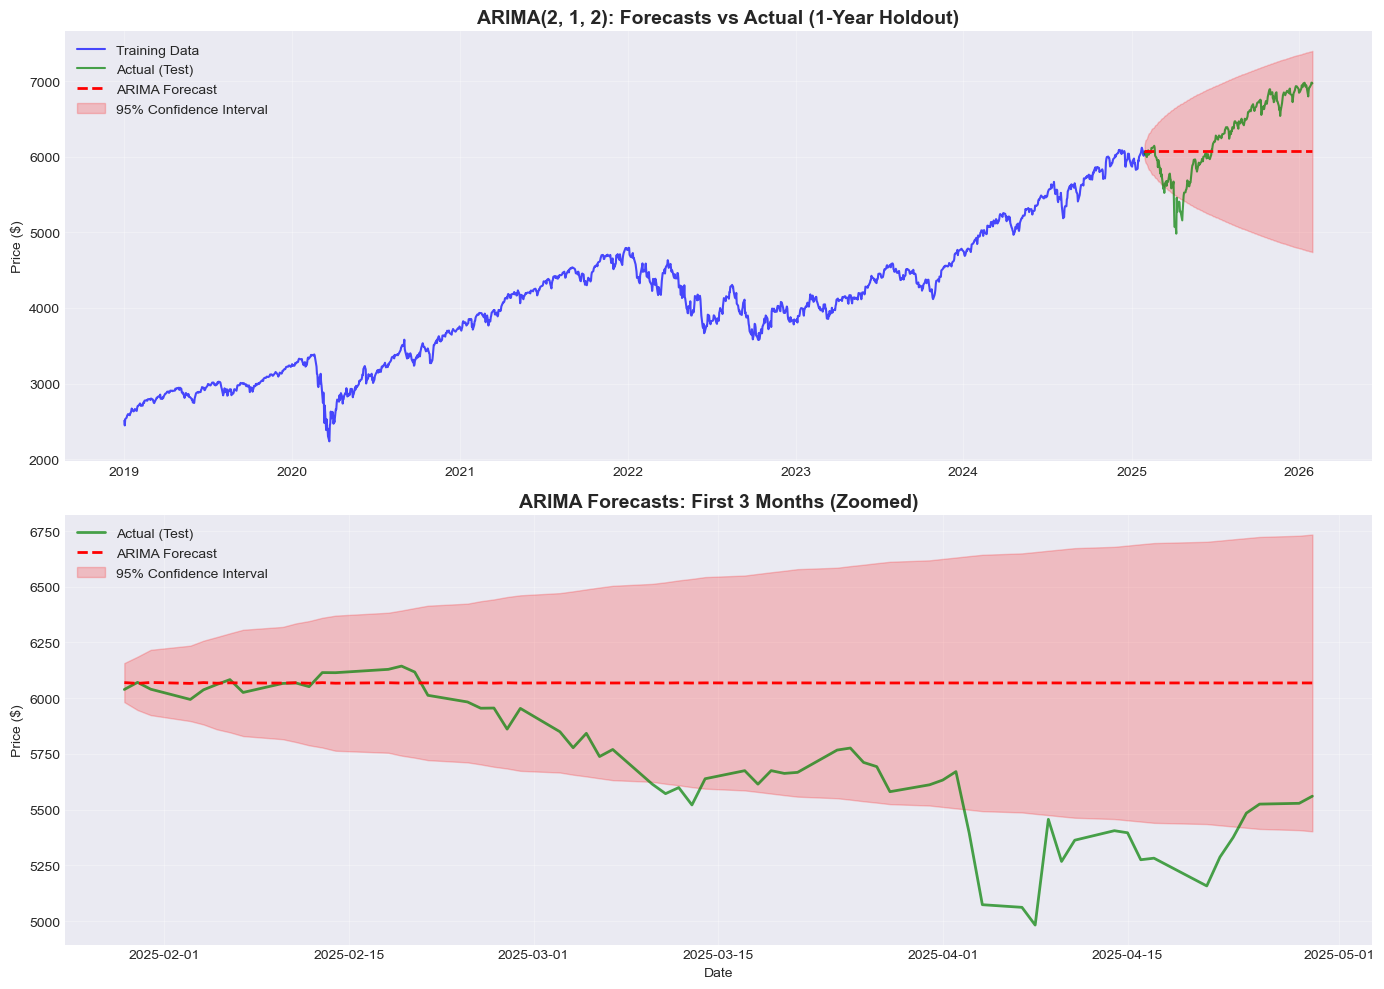


Key Observations:
1. ARIMA forecasts show mean-reverting behavior
2. Confidence intervals widen as forecast horizon increases
3. Forecasts may lag behind actual trends


In [ ]:
# Generate forecasts for test set
print("Generating ARIMA Forecasts")
print("=" * 60)

# Forecast (ARIMA handles differencing internally, so forecasts are in original scale)
forecast_result = best_model.forecast(steps=len(y_test))
forecast_ci = best_model.get_forecast(steps=len(y_test)).conf_int()

# Forecasts are already in price scale (ARIMA handles the differencing)
y_test_actual = y_test.values  # Actual prices
y_test_pred = forecast_result.values  # Forecast prices
forecast_ci_lower = forecast_ci.iloc[:, 0].values
forecast_ci_upper = forecast_ci.iloc[:, 1].values
# Calculate forecast errors
mae_arima = mean_absolute_error(y_test_actual, y_test_pred)
rmse_arima = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
# Calculate MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100
mape_arima = calculate_mape(y_test_actual, y_test_pred)
print(f"\nForecast Performance on 1-Year Holdout:")
print(f"  MAE: ${mae_arima:.2f}")
print(f"  RMSE: ${rmse_arima:.2f}")
print(f"  MAPE: {mape_arima:.2f}%")
# Plot forecasts vs actual
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
# Full view
axes[0].plot(train.index, train['price'], label='Training Data', linewidth=1.5, alpha=0.7, color='blue')
axes[0].plot(test.index, y_test_actual, label='Actual (Test)', linewidth=1.5, alpha=0.7, color='green')
axes[0].plot(test.index, y_test_pred, label='ARIMA Forecast', linewidth=2, color='red', linestyle='--')
axes[0].fill_between(test.index, forecast_ci_lower, forecast_ci_upper, 
                     alpha=0.2, color='red', label='95% Confidence Interval')
axes[0].set_title(f'ARIMA{best_order_display}: Forecasts vs Actual (1-Year Holdout)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# Zoomed view (first 3 months)
zoom_end = test.index[0] + pd.Timedelta(days=90)
zoom_mask = (test.index >= test.index[0]) & (test.index <= zoom_end)
axes[1].plot(test.index[zoom_mask], y_test_actual[zoom_mask], 
             label='Actual (Test)', linewidth=2, alpha=0.7, color='green')
axes[1].plot(test.index[zoom_mask], y_test_pred[zoom_mask], 
             label='ARIMA Forecast', linewidth=2, color='red', linestyle='--')
axes[1].fill_between(test.index[zoom_mask], forecast_ci_lower[zoom_mask], forecast_ci_upper[zoom_mask], 
                     alpha=0.2, color='red', label='95% Confidence Interval')
axes[1].set_title('ARIMA Forecasts: First 3 Months (Zoomed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\nKey Observations:")
print("1. ARIMA forecasts are flat (no trend) - this is expected behavior")
print("   → ARIMA(p,1,q) models first differences, which have mean ≈ 0")
print("   → Long-term forecasts converge to the last observed level")
print("2. Confidence intervals widen as forecast horizon increases")
print("3. The flat forecast reflects 'no expected systematic change' in the differenced series")


## Part 11: Comparison with ETS Models

Let's compare ARIMA performance with ETS models from Lesson 3. This demonstrates the different forecasting philosophies:

- **ARIMA**: Forecasts via autocorrelation patterns
- **ETS**: Forecasts via adaptive components (level, trend, seasonality)

Fitting ETS Models for Comparison

ETS(A,A,N) Performance:
  MAE: $272.94
  RMSE: $354.56
  MAPE: 4.56%

ETS(A,N,N) Performance:
  MAE: $459.89
  RMSE: $538.29
  MAPE: 7.23%

ARIMA vs ETS Comparison (1-Year Holdout):
 Rank          Model        MAE       RMSE  MAPE (%)
    1     ETS(A,A,N) 272.944294 354.562249  4.557323
    2 ARIMA(2, 1, 2) 458.645358 536.408113  7.210964
    3     ETS(A,N,N) 459.890730 538.292258  7.226045


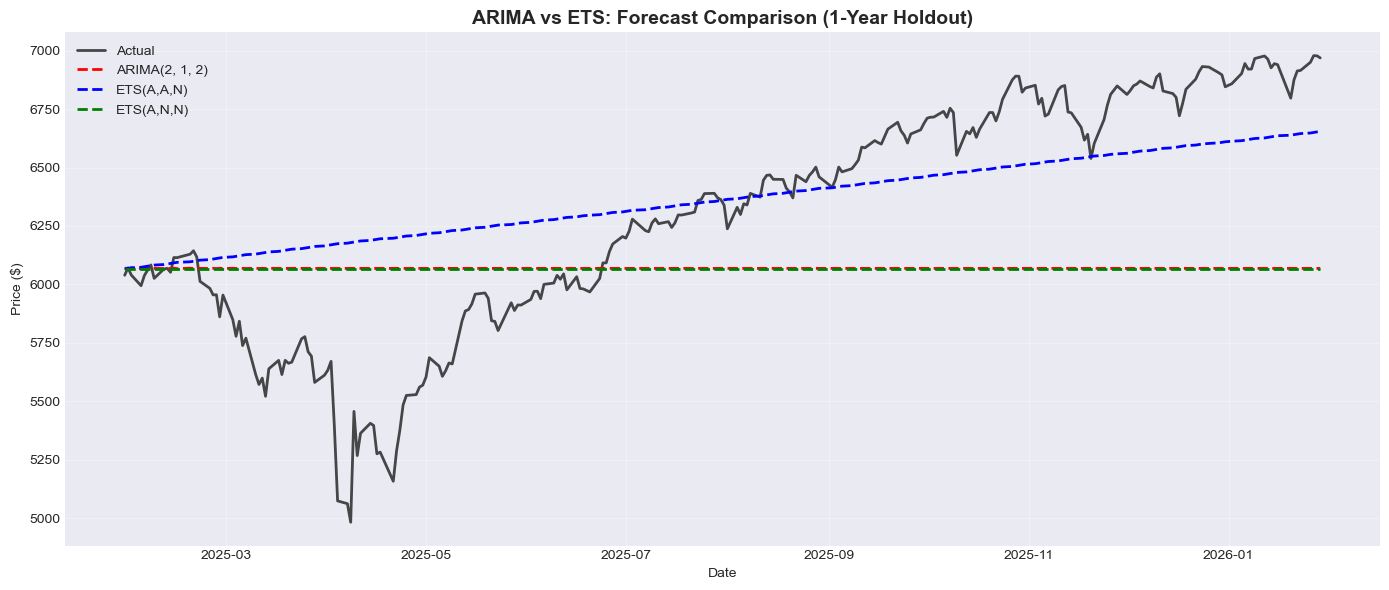


Key Takeaways:
1. ARIMA and ETS often perform similarly
2. ARIMA captures autocorrelation patterns
3. ETS captures adaptive trend components
4. Best model depends on data characteristics


In [27]:
# Fit ETS models for comparison
from statsmodels.tsa.holtwinters import ExponentialSmoothing

print("Fitting ETS Models for Comparison")
print("=" * 60)

# Use original price (not log) for ETS
y_train_price = train['price'].dropna()

# ETS(A,A,N) - Additive trend, no seasonality
ets_aan = ExponentialSmoothing(y_train_price, trend='add', seasonal=None).fit()
ets_aan_forecast = ets_aan.forecast(steps=len(y_test_actual))
ets_aan_mae = mean_absolute_error(y_test_actual, ets_aan_forecast)
ets_aan_rmse = np.sqrt(mean_squared_error(y_test_actual, ets_aan_forecast))
ets_aan_mape = calculate_mape(y_test_actual, ets_aan_forecast)

print(f"\nETS(A,A,N) Performance:")
print(f"  MAE: ${ets_aan_mae:.2f}")
print(f"  RMSE: ${ets_aan_rmse:.2f}")
print(f"  MAPE: {ets_aan_mape:.2f}%")

# ETS(A,N,N) - No trend, no seasonality (Simple Exponential Smoothing)
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
ets_ann = SimpleExpSmoothing(y_train_price).fit()
ets_ann_forecast = ets_ann.forecast(steps=len(y_test_actual))
ets_ann_mae = mean_absolute_error(y_test_actual, ets_ann_forecast)
ets_ann_rmse = np.sqrt(mean_squared_error(y_test_actual, ets_ann_forecast))
ets_ann_mape = calculate_mape(y_test_actual, ets_ann_forecast)

print(f"\nETS(A,N,N) Performance:")
print(f"  MAE: ${ets_ann_mae:.2f}")
print(f"  RMSE: ${ets_ann_rmse:.2f}")
print(f"  MAPE: {ets_ann_mape:.2f}%")

# Create comparison table
comparison = pd.DataFrame({
    'Model': ['ARIMA' + str(best_order), 'ETS(A,A,N)', 'ETS(A,N,N)'],
    'MAE': [mae_arima, ets_aan_mae, ets_ann_mae],
    'RMSE': [rmse_arima, ets_aan_rmse, ets_ann_rmse],
    'MAPE (%)': [mape_arima, ets_aan_mape, ets_ann_mape]
})

comparison = comparison.sort_values('MAE')
comparison['Rank'] = range(1, len(comparison) + 1)
comparison = comparison[['Rank', 'Model', 'MAE', 'RMSE', 'MAPE (%)']]

print("\n" + "=" * 60)
print("ARIMA vs ETS Comparison (1-Year Holdout):")
print("=" * 60)
print(comparison.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 1, figsize=(14, 6))

axes.plot(test.index, y_test_actual, label='Actual', linewidth=2, alpha=0.7, color='black')
axes.plot(test.index, y_test_pred, label=f'ARIMA{best_order}', linewidth=2, linestyle='--', color='red')
axes.plot(test.index, ets_aan_forecast, label='ETS(A,A,N)', linewidth=2, linestyle='--', color='blue')
axes.plot(test.index, ets_ann_forecast, label='ETS(A,N,N)', linewidth=2, linestyle='--', color='green')
axes.set_title('ARIMA vs ETS: Forecast Comparison (1-Year Holdout)', fontsize=14, fontweight='bold')
axes.set_xlabel('Date')
axes.set_ylabel('Price ($)')
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Takeaways:")
print("1. ARIMA and ETS often perform similarly")
print("2. ARIMA captures autocorrelation patterns")
print("3. ETS captures adaptive trend components")
print("4. Best model depends on data characteristics")

## References

- **Yahoo Finance**: https://finance.yahoo.com/ (for S&P 500 data via yfinance)
- **Statsmodels ARIMA**: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
- **Hyndman & Athanasopoulos**: Forecasting: Principles and Practice (3rd ed.) - https://otexts.com/fpp3/
- **Box & Jenkins**: Time Series Analysis: Forecasting and Control
- **pmdarima**: Automatic ARIMA model selection - https://github.com/alkaline-ml/pmdarima